# Predicting SARS-Cov2 Protein-Protein Interactions
### Ami Baid
This project uses a support vector machine to predict protein-protein interactions between the human proteome and the SARS-CoV2 virus proteins using previously known virus-human protein interaction information between human and Zika virus proteins and sequence alignment 


In [5]:
! pip install Biopython
! pip install numpy
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix

# Obtaining and organizing the data 

## Creating the interaction data frame
A CSV file containing experimentally determined protein-protien interactions is converted to a data frame. The data is obtain from UCSF's Krogan Lab and contains protein-protein interaction information for mutiple viruses, including SArs-CoV2 and Zika. The data cotains the virus bait protein and the corresponding human prey protein that it interacted with. That data also contains the MIST score, which indicates the probability of the interaction's occurrence. All cloumns of the data were added to the data frame but only the mentioned ones were used.

In [6]:
ppi_data = pd.read_csv("/Users/amibaid/Downloads/ppi_project/ppi_multipathogen_wCoV2.txt", sep= '\t')
ppi_data['Bait'] = ppi_data.apply(lambda x: x['Bait'].split(" ")[1].upper() if x.dataset == 'SARS-CoV2-HEK293T' else x['Bait'], axis=1)
ppi_data['Bait-Prey'] = ppi_data['Bait']+ '-' + ppi_data['Prey']
ppi_data

,dataset,pathogen,cell_line,Bait,Prey,PreyGeneName,MIST,MIST_origin,Bait-Prey
0,Chlamydia-HEK293T,Chlamydia,HEK293T,CT005,P19784,CSNK2A2,0.950206,0.999608,CT005-P19784
1,Chlamydia-HEK293T,Chlamydia,HEK293T,CT005,Q13445,TMED1,0.949765,0.999571,CT005-Q13445
2,Chlamydia-HEK293T,Chlamydia,HEK293T,CT005,Q9Y3B3,TMED7,0.948138,0.997880,CT005-Q9Y3B3
3,Chlamydia-HEK293T,Chlamydia,HEK293T,CT005,Q15691,MAPRE1,0.948124,0.997817,CT005-Q15691
4,Chlamydia-HEK293T,Chlamydia,HEK293T,CT005,Q9ULK5,VANGL2,0.945743,0.995156,CT005-Q9ULK5
...,...,...,...,...,...,...,...,...,...
232794,SARS-CoV2-HEK293T,SARS-CoV2,HEK293T,SPIKE,Q9Y5V0,ZNF706,0.320555,0.320555,SPIKE-Q9Y5V0
232795,SARS-CoV2-HEK293T,SARS-CoV2,HEK293T,SPIKE,Q9Y5Y2,NUBP2,0.214821,0.214821,SPIKE-Q9Y5Y2
232796,SARS-CoV2-HEK293T,SARS-CoV2,HEK293T,SPIKE,Q9Y606,PUS1,0.353105,0.353105,SPIKE-Q9Y606
232797,SARS-CoV2-HEK293T,SARS-CoV2,HEK293T,SPIKE,Q9Y6K0,CEPT1,0.216346,0.216346,SPIKE-Q9Y6K0


## Creating the Zika virus protein data frame
Data conatining the protein sequences for all Zika virus proteins was obtained from an NIH research project. Each Zika virus protein and its corresponding protein sequence was put into a data frame.

In [7]:
proteins_data = pd.read_excel("/Users/amibaid/Downloads/ppi_project/NIHMS1515954-supplement-7.xlsx")
proteins_data.columns = proteins_data.iloc[0]
proteins_data.drop(0,inplace=True)
proteins_data.reset_index(drop=True, inplace=True)
proteins_data.head(2)

,Bait,Protein Sequence,"DNA Sequence (with 2xStrep tag), Human expression","DNA Sequence (with 2xStrep tag), Human Codon Optimized","DNA Sequence (with 2xStrep tag), Mosquito Codon Optimized","DNA Sequence (with 2xStrep tag), Drosophila Codon Optimized"
0,DENV2 16681 Capsid,MNNQRKKAKNTPFNMLKRERNRVSTVQQLTKRFSLGMLQGRGPLKL...,atgaataaccaacggaaaaaggcgaaaaacacgcctttcaatatgc...,atgaacaaccagaggaaaaaggcaaaaaacacaccattcaatatgc...,atgaacaatcagcgtaagaaagccaaaaacaccccgttcaatatgt...,NaN
1,DENV2 16681 Capsid Anchor,MNNQRKKAKNTPFNMLKRERNRVSTVQQLTKRFSLGMLQGRGPLKL...,atgaataaccaacggaaaaaggcgaaaaacacgcctttcaatatgc...,atgaacaaccagaggaaaaaggcaaaaaacacaccattcaatatgc...,NaN,NaN


The final Zika virus data frame:

In [8]:
zika_df = pd.DataFrame(proteins_data[proteins_data.Bait.isin(ppi_data[ppi_data.dataset == 'Zika-HEK293T'].Bait.unique())])
zika_df.reset_index(drop=True, inplace=True)
zika_df.drop(zika_df.columns[2:], axis=1, inplace=True)
zika_df

,Bait,Protein Sequence
0,ZIKVfp Capsid,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...
1,ZIKVfp NS3,MSGALWDVPAPKEVKKGETTDGVYRVMTRRLLGSTQVGVGVMQEGV...
2,ZIKVfp NS2B3,MSWPPSEVLTAVGLICALAGGFAKADIEMAGPMAAVGLLIVSYVVS...
3,ZIKVfp NS4A,MGAAFGVMEALGTLPGHMTERFQEAIDNLAVLMRAETGSRPYKAAA...
4,ZIKVfp NS5,MGGGTGETLGEKWKARLNQMSALEFYSYKKSGITEVCREEARRALK...
5,ZIKVug Capsid,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...
6,ZIKVug NS3,MSGALWDVPAPKEVKKGETTDGVYRVMTRRLLGSTQVGVGVMQEGV...
7,ZIKVug NS2B3,MSWPPSEVLTAVGLICALAGGFAKADIEMAGPMAAVGLLIVSYVVS...
8,ZIKVug NS4A,MGAALGVMEALGTLPGHMTERFQEAIDNLAVLMRAETGSRPYKAAA...
9,ZIKVug NS5,MGGGTGETLGEKWKARLNQMSALEFYSYKKSGITEVCREEARRALK...


## Creating the human protein data frame
Data conatining the protein sequences for all proteins in the human proteome was obtained from UniProt. Each human protein and its corresponding protein sequence was put into a data frame.

In [9]:
human_df = pd.DataFrame(columns=['Prey', 'Protein Sequence'])
for i in SeqIO.parse('/Users/amibaid/Downloads/ppi_project/UP000005640_9606.fasta', 'fasta'):
  human_df = human_df.append({'Prey': i.id.split('|')[1], 'Protein Sequence': str(i.seq)}, ignore_index= True)

In [10]:
human_df.head()

,Prey,Protein Sequence
0,A0A024R1R8,MSSHEGGKKKALKQPKKQAKEMDEEEKAFKQKQKEEQKKLEVLKAK...
1,A0A024RBG1,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...
2,A0A024RCN7,MERSFVWLSCLDSDSCNLTFRLGEVESHACSPSLLWNLLTQYLPPG...
3,A0A075B6H5,METVVTTLPREGGVGPSRKMLLLLLLLGPGSGLSAVVSQHPSRVIC...
4,A0A075B6H7,MEAPAQLLFLLLLWLPDTTREIVMTQSPPTLSLSPGERVTLSCRAS...


## Creating the positive data frame
From the data frame conatining known Zika-human protein interaction, each pair of interacting Zika virus bait and human prey with a MIST score of over 0.75 was selected. The pair was added to the positive data frame and the corresponding Zika virus and human protein sequences were retrieved from their respective data frames and added.

In [11]:
pos_data = pd.DataFrame(ppi_data[(ppi_data.dataset == 'Zika-HEK293T') & (ppi_data['MIST'] >= 0.75)]).iloc[:, 3:5]
pos_data.reset_index(drop=True, inplace=True)
pos_data = pd.merge(pos_data, zika_df, on='Bait')
pos_data = pd.merge(pos_data, human_df, on='Prey')
pos_data.rename({'Protein Sequence_x': 'Bait Sequence', 'Protein Sequence_y' : 'Prey Sequence'}, axis=1, inplace=True)
pos_data

,Bait,Prey,Bait Sequence,Prey Sequence
0,ZIKVfp Capsid,Q9UGR2,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,MERQKRKADIEKGLQFIQSTLPLKQEEYEAFLLKLVQNLFAEGNDL...
1,ZIKVfp Capsid,O60524,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,MKSRFSTIDLRAVLAELNASLLGMRVNNVYDVDNKTYLIRLQKPDF...
2,ZIKVfp Capsid,Q9NSI2,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,MGKVRGLRARVHQAAVRPKGEAAPGPAPPAPEATPPPASAAGKDWA...
3,ZIKVug Capsid,Q9NSI2,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,MGKVRGLRARVHQAAVRPKGEAAPGPAPPAPEATPPPASAAGKDWA...
4,ZIKVfp Capsid,Q9BYD6,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,MAAAVRCMGRALIHHQRHSLSKMVYQTSLCSCSVNIRVPNRHFAAA...
...,...,...,...,...
699,ZIKVug NS5,P07339,MGGGTGETLGEKWKARLNQMSALEFYSYKKSGITEVCREEARRALK...,MQPSSLLPLALCLLAAPASALVRIPLHKFTSIRRTMSEVGGSVEDL...
700,ZIKVug NS5,Q8N954,MGGGTGETLGEKWKARLNQMSALEFYSYKKSGITEVCREEARRALK...,MRSARSTALNRGEQRAVRYYSHMKLNMAEEEDYMSDSFINVQEDIR...
701,ZIKVug NS5,O15042,MGGGTGETLGEKWKARLNQMSALEFYSYKKSGITEVCREEARRALK...,MADKTPGGSQKASSKTRSSDVHSSGSSDAHMDASGPSDSDMPSRTR...
702,ZIKVug NS5,P13807,MGGGTGETLGEKWKARLNQMSALEFYSYKKSGITEVCREEARRALK...,MPLNRTLSMSSLPGLEDWEDEFDLENAVLFEVAWEVANKVGGIYTV...


## Creating the negative data frame
The negative data was selected by matching each Zika virus prey protein to a human protein not found in the interaction data frame, ensuring there is no interaction between the two proteins. The non-interacting virus bait and human prey proteins were added to the negative data frame. The corresponding Zika virus and human protein sequences were retrieved from their respective data frames and added.

In [12]:
neg_data = pd.DataFrame(zika_df)
neg_data = pd.concat([neg_data]*140, ignore_index=True)
neg_data = neg_data.rename(columns={"Protein Sequence": "Bait Sequence"})
neg_human_data = human_df[~human_df.Prey.isin(ppi_data.Prey.unique())].sample(n=1400, random_state=22)
neg_human_data.reset_index(drop=True, inplace=True)
neg_human_data = neg_human_data.rename(columns={"Protein Sequence": "Prey Sequence"})
neg_data = pd.concat([neg_data, neg_human_data], axis=1)
neg_data = neg_data[['Bait', 'Prey', 'Bait Sequence', 'Prey Sequence']]
neg_data

,Bait,Prey,Bait Sequence,Prey Sequence
0,ZIKVfp Capsid,Q2TBC4,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,MSPQGPAVLSLGSLCLDTNQAPNWTGLQTLLQQLPPQDIDERYCLA...
1,ZIKVfp NS3,P0DO92,MSGALWDVPAPKEVKKGETTDGVYRVMTRRLLGSTQVGVGVMQEGV...,MASTPMGNEGEKKSSWPSQAAPSLRGGPASLSRSEEYLSQISAELM...
2,ZIKVfp NS2B3,P23409,MSWPPSEVLTAVGLICALAGGFAKADIEMAGPMAAVGLLIVSYVVS...,MMMDLFETGSYFFYLDGENVTLQPLEVAEGSPLYPGSDGTLSPCQD...
3,ZIKVfp NS4A,Q8N8S7,MGAAFGVMEALGTLPGHMTERFQEAIDNLAVLMRAETGSRPYKAAA...,MSEQSICQARAAVMVYDDANKKWVPAGGSTGFSRVHIYHHTGNNTF...
4,ZIKVfp NS5,Q9UN74,MGGGTGETLGEKWKARLNQMSALEFYSYKKSGITEVCREEARRALK...,MEFSWGSGQESRRLLLLLLLLAAWEAGNGQLHYSVSEEAKHGTFVG...
...,...,...,...,...
1395,ZIKVug Capsid,A8MYV0,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,MGTRGPSAPVDTTPAKTIVVYRNGDPFYVGKKFVLSRRRAATFEAL...
1396,ZIKVug NS3,P31249,MSGALWDVPAPKEVKKGETTDGVYRVMTRRLLGSTQVGVGVMQEGV...,MLFEQGQQALELPECTMQKAAYYENPGLFGGYGYSKTTDTYGYSTP...
1397,ZIKVug NS2B3,Q5VVC0,MSWPPSEVLTAVGLICALAGGFAKADIEMAGPMAAVGLLIVSYVVS...,MAESGKEKIKWTTTIIISSSLKSYEVATALENRSHKVRYSDSVENG...
1398,ZIKVug NS4A,F5H4B4,MGAALGVMEALGTLPGHMTERFQEAIDNLAVLMRAETGSRPYKAAA...,MNHFRKMEVINLTTLPMIPVDEHLAVSLVARNTMVKTVRKELENNP...


# Adding the features of the data

## Sequence alignment
One predicted variable that could help predict the interaction between two proteins is the similarilty of their sequences. Using a global pairwise alignment algorithm, the sequence alignment scores for each bait and prey pair were added to the positive and negative data frames.

In [13]:
pos_scores = []
for i in range(len(pos_data["Bait"])):
    X = pos_data["Bait Sequence"][i]
    Y = pos_data["Prey Sequence"][i]
    alignments = pairwise2.align.globalxx(X, Y)
    pos_scores.append(alignments[0][2])

In [14]:
neg_scores = []
for i in range(len(neg_data["Bait"])):
    X = neg_data["Bait Sequence"][i]
    Y = neg_data["Prey Sequence"][i]
    alignments = pairwise2.align.globalxx(X, Y)
    neg_scores.append(alignments[0][2])

The histogram of the distribution of alignment scores for the positive and negative data. Unfortunately, the association was not as strong as expected.

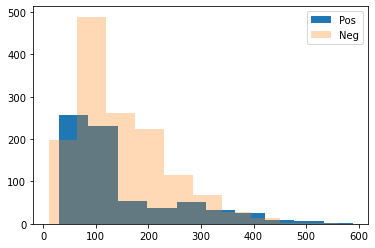

In [15]:
plt.hist(pos_scores, alpha=1, label='Pos')
plt.hist(neg_scores, alpha=0.3, label='Neg')
plt.legend(loc='upper right')
plt.show()

## Bait protein length
Another variable that could help predict and interaction was bait protein lenght. So the lenght of the bait protein in each bait-prey pair was added to the postive and negative data frames.

In [16]:
pos_data['y_true'], neg_data['y_true'] = 1, 0
pos_data["Score"], neg_data['Score'] = pos_scores, neg_scores
pos_data["Bait Length"], neg_data["Bait Length"] = pos_data.apply(lambda x: len(x['Bait Sequence']), axis=1), neg_data.apply(lambda x: len(x['Bait Sequence']), axis=1)

## Amino acid counts
The third variable used to possibly help predict the interaction between a bait and prey protein was the amino acid counts of both protein sequences. So, the amount of the 4 types of amino acids in each bait and prey protein sequence was calculated and added to the postive and negative data frame.

In [17]:
def classify_amino_acids(seq):
    charged = 0
    polar = 0
    amphiatic = 0
    hydrophobic = 0
    
    for i in seq:
        if i in ['R', 'K', 'D', 'E']:
            charged += 1
        elif i in ['Q', 'N', 'H', 'S', 'T', 'Y', 'C']:
            polar += 1
        elif i in ['W', 'Y', 'M']:
            amphiatic += 1
        elif i in ['A', 'I', 'L', 'M', 'F', 'V', 'P', 'G']:
            hydrophobic += 1
            
    return [charged, polar, amphiatic, hydrophobic]

In [18]:
def add_amino_acid_counts(df):
    cols = ['Bait charged', 'Bait polar', 'Bait amphiatic', 'Bait hydrophobic', 'Prey charged', 'Prey polar', 'Prey amphiatic', 'Prey hydrophobic']
    for i in range(8):
        conditional = 'Bait Sequence' if 'Bait' in cols[i] else 'Prey Sequence'
        df[cols[i]] = df.apply(lambda x: classify_amino_acids(x[conditional])[i%4], axis=1)

add_amino_acid_counts(pos_data)
add_amino_acid_counts(neg_data)

## Atomic weight of bait protein
The last variable used to possibly help predict the interaction between two proteins was the atomic weight of the bait protein. The weight vlaues for each virus bait protein were claculated using and external calulator and added to the data frame.

In [19]:
weight_df = pd.DataFrame(zika_df.iloc[:, 0])
weight_df['Bait Weight'] = [15217.47, 72217.52, 85983.51, 17429.01, 106577.33, 15238.50, 72076.52, 85875.54, 17395.03, 106611.34]
pos_data, neg_data = pd.merge(pos_data, weight_df, on='Bait'), pd.merge(neg_data, weight_df, on='Bait')

In [20]:
pos_data.head(2)

,Bait,Prey,Bait Sequence,Prey Sequence,y_true,Score,Bait Length,Bait charged,Bait polar,Bait amphiatic,Bait hydrophobic,Prey charged,Prey polar,Prey amphiatic,Prey hydrophobic,Bait Weight
0,ZIKVfp Capsid,Q9UGR2,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,MERQKRKADIEKGLQFIQSTLPLKQEEYEAFLLKLVQNLFAEGNDL...,1,114.0,142,36,19,8,78,256,283,35,403,15217.47
1,ZIKVfp Capsid,O60524,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,MKSRFSTIDLRAVLAELNASLLGMRVNNVYDVDNKTYLIRLQKPDF...,1,118.0,142,36,19,8,78,352,288,31,405,15217.47


# Creating and testing the model

## Combining the positive and negative data frames
The positive and negative data frames were combined to form the full data frame contain the bait and prey proteins, their sequences, all 11 features of each interaction, and whether was interaction was from the postive or negative data frame.

In [21]:
all_data = pd.DataFrame(pd.concat([pos_data, neg_data], axis=0, ignore_index= True))
pca = PCA(2)
pca_data = all_data.iloc[:, 5:]
pca.fit(pca_data)
x_pca = pd.DataFrame(pca.transform(pca_data), columns =['1', '2'])
x_pca['y_true'] = pd.DataFrame(all_data['y_true'])

In [22]:
all_data.head(2)

,Bait,Prey,Bait Sequence,Prey Sequence,y_true,Score,Bait Length,Bait charged,Bait polar,Bait amphiatic,Bait hydrophobic,Prey charged,Prey polar,Prey amphiatic,Prey hydrophobic,Bait Weight
0,ZIKVfp Capsid,Q9UGR2,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,MERQKRKADIEKGLQFIQSTLPLKQEEYEAFLLKLVQNLFAEGNDL...,1,114.0,142,36,19,8,78,256,283,35,403,15217.47
1,ZIKVfp Capsid,O60524,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,MKSRFSTIDLRAVLAELNASLLGMRVNNVYDVDNKTYLIRLQKPDF...,1,118.0,142,36,19,8,78,352,288,31,405,15217.47


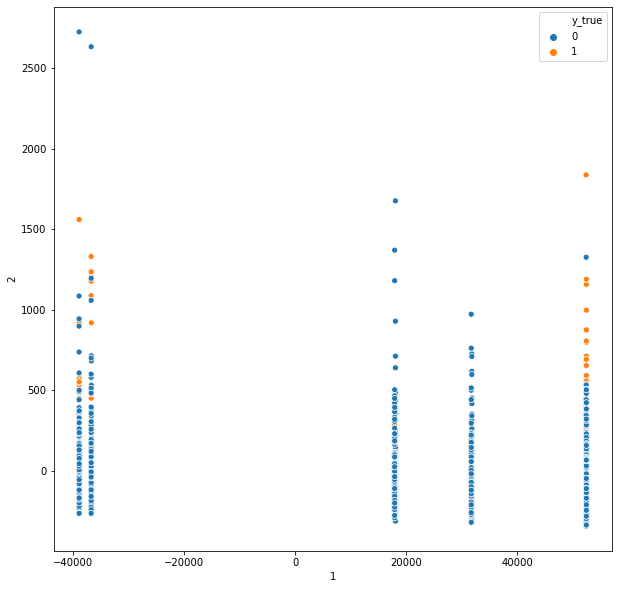

In [23]:
fig,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='1', y='2', hue='y_true', data=x_pca)

## Splitting the data
20% of all the interacting bait-prey pairs and 20% of the non-interacting bait-prey pairs are randomly selected to form the training set for the model.

In [24]:
y_true = all_data.iloc[:, 4]
X_train, X_test, y_train, y_test = train_test_split(all_data, y_true , stratify=y_true, test_size=0.2,random_state=5)

In [25]:
X_train.head(2)

,Bait,Prey,Bait Sequence,Prey Sequence,y_true,Score,Bait Length,Bait charged,Bait polar,Bait amphiatic,Bait hydrophobic,Prey charged,Prey polar,Prey amphiatic,Prey hydrophobic,Bait Weight
1283,ZIKVfp NS5,Q0P6H9,MGGGTGETLGEKWKARLNQMSALEFYSYKKSGITEVCREEARRALK...,MAAVLALRVVAGLAAAALVAMLLEHYGLAGQPSPLPRPAPPRRPHP...,0,272.0,942,248,242,67,384,103,193,24,323,106577.33
1143,ZIKVfp NS4A,Q66K41,MGAAFGVMEALGTLPGHMTERFQEAIDNLAVLMRAETGSRPYKAAA...,MLLGPASGAPSPLLASLPLPTRPLQPPLDFKHLLAFHFNGAAPLSL...,0,81.0,166,26,28,13,98,69,121,7,225,17429.01


## The classifier
A support vector machine is created and fitted with our training data set. It is then tested using the training data set and is able to predict Zika-human protein interations with the displayed accuracy.

In [26]:
clf = svm.SVC(kernel='linear', random_state=20)
clf = clf.fit(X_train.iloc[:, 5:], y_train)
accuracy = clf.score(X_test.iloc[:, 5:], y_test)
accuracy

0.7529691211401425

The confusion matrix for the first support vector machine

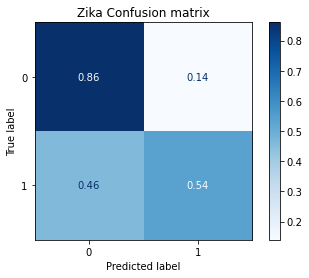

In [28]:
matrix = plot_confusion_matrix(clf, X_test.iloc[:, 5:], y_test, cmap=plt.cm.Blues,normalize='true')
plt.title('Zika Confusion matrix')
plt.show(matrix)
plt.show()

## Testing the model on SARS-CoV2 
A new support vector machine classifier was fitted with the virus-protein interaction data frame and tested by prdeicting with SARS-CoV2 proteins will interact with which human proteins.

In [29]:
sars_df = pd.read_csv("/Users/amibaid/Downloads/ppi_project/sars_test_df .txt", sep = '\t')
sars_df.head(2)

,Bait,Prey,Bait Sequence,Prey Sequence,Score,Bait_Weight,Bait_Length,Bait_charged,Bait_polar,Bait_amphipathic,Bait_hydrophobic,Prey_charged,Prey_polar,Prey_amphipathic,Prey_hydrophobic,Bait-Prey,y_true
0,orf9c,A0A024R1R8,LQSCYNFLKEQHCQKASTQKGAEAAVKPLLVPHHVVATVQEIQLQA...,MSSHEGGKKKALKQPKKQAKEMDEEEKAFKQKQKEEQKKLEVLKAK...,20.0,7918.3892,72,10,22,4,39,29,10,2,25,orf9c-A0A024R1R8,0
1,orf9c,A0A024RBG1,LQSCYNFLKEQHCQKASTQKGAEAAVKPLLVPHHVVATVQEIQLQA...,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,37.0,7918.3892,72,10,22,4,39,52,46,12,80,orf9c-A0A024RBG1,0


In [30]:
all_data.head(2)

,Bait,Prey,Bait Sequence,Prey Sequence,y_true,Score,Bait Length,Bait charged,Bait polar,Bait amphiatic,Bait hydrophobic,Prey charged,Prey polar,Prey amphiatic,Prey hydrophobic,Bait Weight
0,ZIKVfp Capsid,Q9UGR2,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,MERQKRKADIEKGLQFIQSTLPLKQEEYEAFLLKLVQNLFAEGNDL...,1,114.0,142,36,19,8,78,256,283,35,403,15217.47
1,ZIKVfp Capsid,O60524,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,MKSRFSTIDLRAVLAELNASLLGMRVNNVYDVDNKTYLIRLQKPDF...,1,118.0,142,36,19,8,78,352,288,31,405,15217.47


In [31]:
clf2 = svm.SVC(kernel='linear', random_state=20)
clf2 = clf.fit(all_data.iloc[:, 5:], all_data['y_true'])
accuracy2 = clf.score(sars_df.iloc[:, 4:15], sars_df['y_true'])
accuracy2

0.9768623114560974

The confusion matrix for the second support vector machine

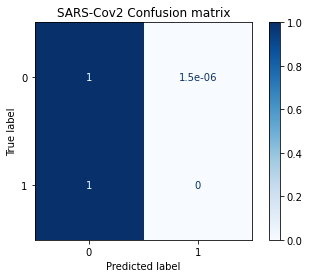

In [33]:
matrix = plot_confusion_matrix(clf, sars_df.iloc[:, 4:15], sars_df['y_true'], cmap=plt.cm.Blues,normalize='true')
plt.title('SARS-Cov2 Confusion matrix')
plt.show(matrix)
plt.show()

## Conclusion
When used to try and predict interactions between SARS-CoV2 proteins and human proteins, the model did not perform well. Further analysis is needed to draw conclusions about which features were useful, if any, and what feautures need to be added in the future to increase the accuacy of the model.